In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Uyarıları görmezden gelme
warnings.filterwarnings('ignore')

# Veri Yükleme ve Veri Ön İşleme

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dosya yolu
file_path = 'C:/Users/erend/Desktop/Innova - Hackathon/Veri Seti/hackathon 2024 - Yapay Zeka(yeni).xlsx'

# Excel dosyası yükleme
data = pd.read_excel(file_path, sheet_name='Sheet1')

In [3]:
# Eksik Değerlerin Kontrolü
missing_values = data.isnull().sum()
print("Eksik Değerler:\n", missing_values)

Eksik Değerler:
 TIME_STAMP     0
SERVER_NAME    0
DOWNLOAD       2
UPLOAD         2
dtype: int64


In [4]:
# Veri Tiplerinin Kontrolü
data_types = data.dtypes
print("Veri Tipleri:\n", data_types)

Veri Tipleri:
 TIME_STAMP     datetime64[ns]
SERVER_NAME            object
DOWNLOAD              float64
UPLOAD                float64
dtype: object


In [ ]:
# Zaman Damgası (Timestamp) Dönüşümü
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

# Veri Görselleştirme

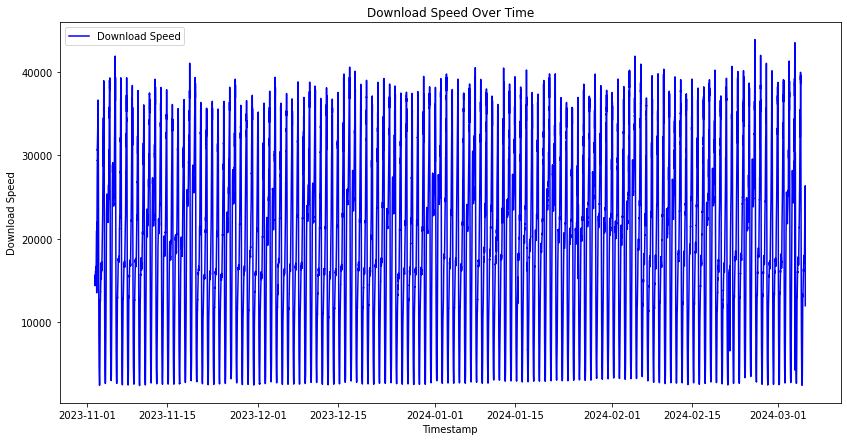

In [5]:
# Download hızı için zaman serisi grafiği
plt.figure(figsize=(14, 7))
plt.plot(data['TIME_STAMP'], data['DOWNLOAD'], label='Download Speed', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Download Speed')
plt.title('Download Speed Over Time')
plt.legend()
plt.show()

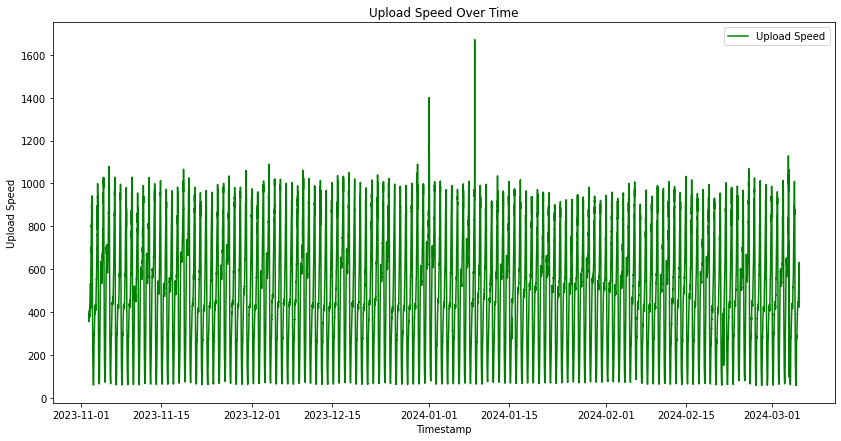

In [6]:
# Upload hızı için zaman serisi grafiği
plt.figure(figsize=(14, 7))
plt.plot(data['TIME_STAMP'], data['UPLOAD'], label='Upload Speed', color='green')
plt.xlabel('Timestamp')
plt.ylabel('Upload Speed')
plt.title('Upload Speed Over Time')
plt.legend()
plt.show()

# Model Kurma (ARIMA)

In [14]:
#data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])
#data.set_index('TIME_STAMP', inplace=True)

# Sadece indirilen ve yüklenen hızlar ile çalışacağımızı varsayalım
download_data = data['DOWNLOAD']
upload_data = data['UPLOAD']

# Veriyi haftalık ortalamalar ile yeniden örnekleme
weekly_data = download_data.resample('W').mean()
weekly_upload_data = upload_data.resample('W').mean()


# İlk birkaç satırı görüntüleme
print(weekly_data.head())
print(weekly_upload_data.head())

TIME_STAMP
2023-11-05    20659.947277
2023-11-12    18716.523513
2023-11-19    19376.346228
2023-11-26    18317.374408
2023-12-03    18193.247306
Freq: W-SUN, Name: DOWNLOAD, dtype: float64
TIME_STAMP
2023-11-05    522.401703
2023-11-12    480.639836
2023-11-19    509.662759
2023-11-26    481.036119
2023-12-03    483.651077
Freq: W-SUN, Name: UPLOAD, dtype: float64


In [33]:
# ARIMA modelini tanımlama
model = ARIMA(weekly_data, order=(3, 1, 0))

# Modeli eğitme
model_fit = model.fit()

# Model özetini görüntüleme
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               DOWNLOAD   No. Observations:                   19
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -145.690
Date:                Thu, 25 Jul 2024   AIC                            299.380
Time:                        14:00:52   BIC                            302.941
Sample:                    11-05-2023   HQIC                           299.871
                         - 03-10-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2525      0.395     -0.639      0.523      -1.027       0.522
ar.L2         -0.0207      0.700     -0.030      0.976      -1.394       1.352
ar.L3         -0.1065      0.553     -0.193      0.8

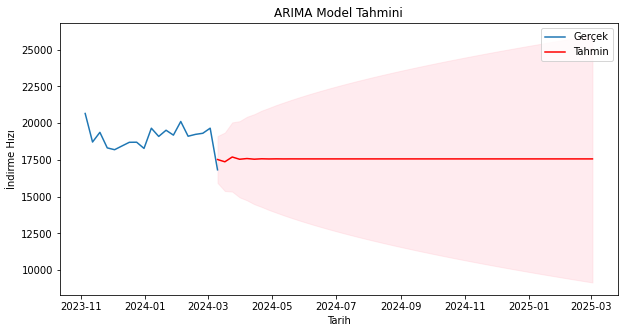

In [34]:
# Gelecek 52 hafta için tahmin yapma
forecast = model_fit.get_forecast(steps=52)
forecast_index = pd.date_range(start=weekly_data.index[-1], periods=52, freq='W')

# Tahmin edilen değerleri ve güven aralıklarını alma
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Gerçek ve tahmin edilen değerleri çizme
plt.figure(figsize=(10, 5))
plt.plot(weekly_data, label='Gerçek')
plt.plot(forecast_index, forecast_mean, label='Tahmin', color='red')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('ARIMA Model Tahmini')
plt.xlabel('Tarih')
plt.ylabel('İndirme Hızı')
plt.legend()
plt.show()

In [37]:
#tahminlerin excel dosyasına kaydedilmesi

# Gelecek 52 hafta için tahmin yapma
forecast = model_fit.get_forecast(steps=52)
forecast_index = pd.date_range(start=weekly_data.index[-1], periods=52, freq='W')

# Tahmin edilen değerleri ve güven aralıklarını alma
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Tahmin sonuçlarını bir DataFrame'e koyma
forecast_df = pd.DataFrame({
    'Tarih': forecast_index,
    'Tahmin Edilen Değerler': forecast_mean,
    'Alt Güven Aralığı': forecast_conf_int.iloc[:, 0],
    'Üst Güven Aralığı': forecast_conf_int.iloc[:, 1]
})

# DataFrame'i bir Excel dosyasına yazma
forecast_df.to_excel('C:/Users/erend/Desktop/Innova - Hackathon/Veri Seti/Tahminler/forecast_results_download.xlsx', index=False)

print("Tahminler 'forecast_results.xlsx' dosyasına yazıldı.")

Tahminler 'forecast_results.xlsx' dosyasına yazıldı.


                               SARIMAX Results                                
Dep. Variable:                 UPLOAD   No. Observations:                   19
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 -77.506
Date:                Thu, 25 Jul 2024   AIC                            163.012
Time:                        14:02:00   BIC                            166.574
Sample:                    11-05-2023   HQIC                           163.503
                         - 03-10-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7003      0.934     -0.750      0.454      -2.531       1.131
ar.L2          0.1809      1.425      0.127      0.899      -2.611       2.973
ar.L3          0.0122      0.897      0.014      0.9

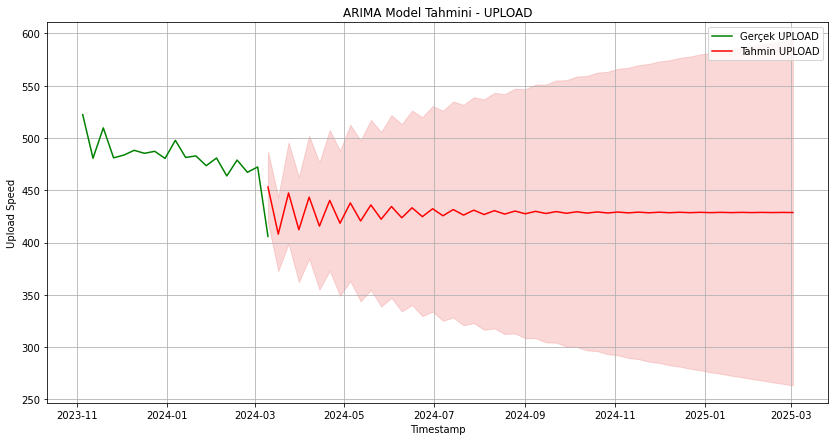

In [38]:
# UPLOAD için ARIMA modelini tanımlama ve eğitme
upload_model = ARIMA(weekly_upload_data, order=(3, 1, 0))
upload_model_fit = upload_model.fit()

# Sonucun yansıtılması
print(upload_model_fit.summary())

# UPLOAD için gelecek 52 hafta için tahmin yapma
upload_forecast = upload_model_fit.get_forecast(steps=52)
upload_forecast_index = pd.date_range(start=weekly_upload_data.index[-1], periods=52, freq='W')
upload_forecast_mean = upload_forecast.predicted_mean
upload_forecast_conf_int = upload_forecast.conf_int()

# Gerçek ve tahmin edilen değerleri çizme
plt.figure(figsize=(14, 7))
plt.plot(weekly_upload_data, label='Gerçek UPLOAD', color='green')
plt.plot(upload_forecast_index, upload_forecast_mean, label='Tahmin UPLOAD', color='red')
plt.fill_between(upload_forecast_index, 
                 upload_forecast_conf_int.iloc[:, 0], 
                 upload_forecast_conf_int.iloc[:, 1], 
                 color='lightcoral', alpha=0.3)
plt.xlabel('Timestamp')
plt.ylabel('Upload Speed')
plt.title('ARIMA Model Tahmini - UPLOAD')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# UPLOAD için tahmin sonuçlarını bir DataFrame'e koyma
upload_forecast_df = pd.DataFrame({
    'Tarih': upload_forecast_index,
    'Tahmin Edilen Değerler': upload_forecast_mean,
    'Alt Güven Aralığı': upload_forecast_conf_int.iloc[:, 0],
    'Üst Güven Aralığı': upload_forecast_conf_int.iloc[:, 1]
})

# DataFrame'i bir Excel dosyasına yazma
upload_forecast_df.to_excel('C:/Users/erend/Desktop/Innova - Hackathon/Veri Seti/Tahminler/forecast_results_upload.xlsx', index=False)

print("UPLOAD tahminleri 'upload_forecast_results.xlsx' dosyasına yazıldı.")

UPLOAD tahminleri 'upload_forecast_results.xlsx' dosyasına yazıldı.


# BONUS

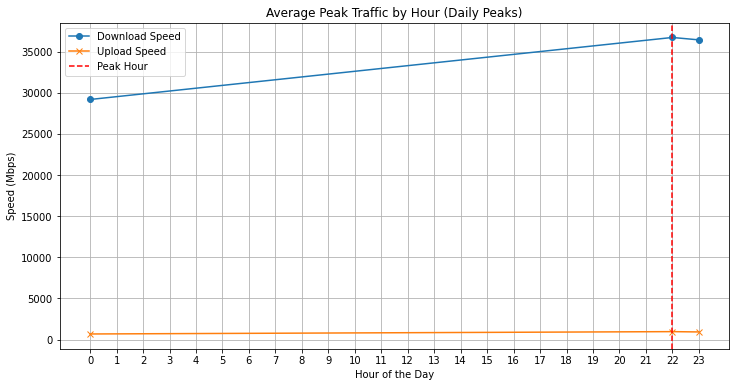

En Yoğun Trafik Saatleri ve Hızları (Günlük Ortalamalar):
   HOUR      DOWNLOAD      UPLOAD
1    22  36717.278156  966.878147
2    23  36424.468642  928.756655
0     0  29181.112455  682.143500


In [41]:
# TIME_STAMP sütunundan tarih ve saat bilgisini çıkartma
df['DATE'] = df['TIME_STAMP'].dt.date
df['HOUR'] = df['TIME_STAMP'].dt.hour

# Her gün için en yoğun saat dilimlerini hesaplama
peak_hours = df.groupby(['DATE', 'HOUR'])[['DOWNLOAD', 'UPLOAD']].mean().reset_index()
peak_hours['TOTAL_TRAFFIC'] = peak_hours['DOWNLOAD'] + peak_hours['UPLOAD']
daily_peak_hours = peak_hours.loc[peak_hours.groupby('DATE')['TOTAL_TRAFFIC'].idxmax()].reset_index(drop=True)

# Tüm günlerin en yoğun saat dilimlerinin ortalamasını hesaplama
average_peak_hours = daily_peak_hours.groupby('HOUR')[['DOWNLOAD', 'UPLOAD']].mean().reset_index()

# Veriyi indirme ve yükleme hızlarına göre sıralama
sorted_average_peak_hours = average_peak_hours.sort_values(by=['DOWNLOAD', 'UPLOAD'], ascending=False)

# En yoğun trafik saatlerini belirleme
top_average_peak_hours = sorted_average_peak_hours.head(5)

# En yoğun saatleri görsel olarak göster
plt.figure(figsize=(12, 6))
plt.plot(average_peak_hours['HOUR'], average_peak_hours['DOWNLOAD'], marker='o', label='Download Speed')
plt.plot(average_peak_hours['HOUR'], average_peak_hours['UPLOAD'], marker='x', label='Upload Speed')
plt.axvline(x=top_average_peak_hours['HOUR'].values[0], color='r', linestyle='--', label='Peak Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Speed (Mbps)')
plt.title('Average Peak Traffic by Hour (Daily Peaks)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

# En yoğun saatleri ve ilgili hızları tablo olarak göster
print("En Yoğun Trafik Saatleri ve Hızları (Günlük Ortalamalar):")
print(top_average_peak_hours)